In [1]:
# pip install sklearn
# sklearn.__version__
# !pip install -U scikit-learn==1.1.0

In [2]:
#!/usr/bin/python
import random
import numpy as np
# import operator
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers.convolutional import Convolution2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.convolutional import Convolution1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence

##### !!! NOTICE: input1為初版沒有考慮company embedding !!! #####

### 同matrix不同label，還是會出現？？？ ### => 合併漲跌

### 選擇適當的quantile threshold ###

from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


import pandas as pd
from sklearn.utils import shuffle
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers, models
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time
import sklearn
# import seaborn as sns

from wakepy import set_keepawake, unset_keepawake
set_keepawake(keep_screen_awake=True)

def value2int(y, clusters=2):
    label = np.copy(y)
    label[y < np.percentile(y, 100 / clusters)] = 0
    for i in range(1, clusters):
        label[y > np.percentile(y, 100 * i / clusters)] = i
    return label

def value2int_simple(y):
    label = np.copy(y)
    label[y < 0] = 0
    label[y >= 0] = 1
    return label

def get_Train_Feature_Label(clusters=2, files=[], loc='', hasJunk=True):
    ##### train #####
    # data_files = [f for f in os.listdir(loc) if f.endswith('train.csv')]
    # data_files += [f for f in os.listdir(loc) if f.endswith('validation.csv')]
    data = pd.DataFrame()
    # for file in data_files[-150:]: # 只train部分
    for file in files: # train全部
#         print(file)
        data = pd.concat([data, pd.read_csv(loc+file)])
    
    shuffle(data)
    X, y = data.iloc[:, 1:-1], data.iloc[:, -1]
    y = value2int_simple(y)

    epoch = 10
#     print('Mean(y): ', np.mean(y))
    if np.mean(y) <= 0.55:
        epoch = 20

    # y = preprocessing.LabelEncoder().fit_transform(y)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    # X, y = SMOTE().fit_resample(X, y)
    # X, y = TomekLinks().fit_resample(X, y)
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    # X_valid, y_valid = SMOTE().fit_resample(X_valid, y_valid)

    X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
    # X_valid, y_valid = TomekLinks().fit_resample(X_valid, y_valid)
#     print('Mean(y_train): ', np.mean(y_train))
    y_train = to_categorical(y_train).astype("int")
    y_valid = to_categorical(y_valid).astype("int")
    # print(X, y)
    # label = to_categorical(value2int_simple(y)).astype("int") # using direction to label
    #label = to_categorical(value2int(y, clusters)).astype("int") # using quantile to label
    # validation_ratio = 0.2
    X_train = X_train.values.reshape(X_train.shape[0], 30, 100, 1).astype('float32')
    X_valid = X_valid.values.reshape(X_valid.shape[0], 30, 100, 1).astype('float32')

    # D = int(data.shape[0] * validation_ratio)  # total number of validation data
    # X_train, y_train, X_valid, y_valid = X[:-D], label[:-D,:], X[-D:], label[-D:,:]

    # return X_train, y_train, X_valid, y_valid, epoch
    return X_train, y_train, X_valid, y_valid
    # np.save('./input2/X_train', X_train)
    # np.save('./input2/y_train', y_train)
    # np.save('./input2/X_valid', X_valid)
    # np.save('./input2/y_valid', y_valid)
    # del X_train, y_train, X_valid, y_valid

def get_Test_Feature_Label(clusters=2, files=[], hasJunk=True):
    ##### test #####
    if not os.path.exists('./input2/X_test.npy'):
        test = pd.DataFrame()
        for i in ['2021/', '2020/']:
            loc = './input2/stockFeatures_ForCNN/'
            loc += i
            files = sorted([f for f in os.listdir(loc) if f.endswith('test.csv')])
            # print(files)
            for file in files:
                print(file)
                test = pd.concat([test, pd.read_csv(loc+file)])
            # print(test.shape)
        X_test, y_test = test.iloc[:, 1:-1], test.iloc[:, -1]

        print("Positive News Ratio", sum(y_test > 0) * 1. / (sum(y_test > 0) + sum(y_test < 0)))
        X_test = X_test.values.reshape(X_test.shape[0], 30, 100, 1).astype('float32')
        y_test = to_categorical(value2int_simple(y_test)).astype("int")
        np.save('./input2/X_test', X_test)
        np.save('./input2/y_test', y_test)
        return X_test, y_test
    else:
        pass

def CNN(clusters=2):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 100), activation='relu', input_shape=(30, 100, 1))) # output channel, kernel size, input shape, input channel
    model.add(layers.MaxPooling2D((28, 1))) # 30-3+1 = 28 !!!
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(clusters, activation='softmax'))
    model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

def evaluate(model, clusters, X_train, y_train, X_valid, y_valid, X_test, y_test, idx):
    model = keras.models.load_model('./input2/WB_CNN_Model.h5')
    
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=1024, verbose=0)
    # Final evaluation of the model
    score = model.evaluate(X_test, y_test, verbose=0)
#     print(score)
    predictions = np.argmax(model.predict(X_valid), axis=-1)
    conf = confusion_matrix(np.argmax(y_valid, axis=-1), predictions)
#     print(conf)
#     for i in range(clusters):
#         print("Valid Label %d Precision, %.2f%%" % (i, conf[i,i] * 100.0 / sum(conf[:,i])))
#     print(f1_score(np.argmax(y_valid, axis=-1), predictions))



    # calculate test predictions
    predictions = model.predict(X_test)
    # print(predictions)
    # print(y_test)
    fallThres = np.quantile(predictions[:, 0], 0.998)
    riseThres = np.quantile(predictions[:, 1], 0.998)
    
    precisionandscore = pd.DataFrame(columns=['Id', 'Threshhold', 'Precision0', 'Precision1', 'F1-Score', 'Accuracy'])
    
    for thres in [0.5, 0.6, 0.65, 0.7, 0.75]:
        try:
#             print('\nThreshold:', thres)
            y_cut = (predictions[:,0] > thres) | (predictions[:,1] > thres) # cut y value and leave the better result
            predictions_2 = np.argmax(predictions[y_cut], axis=-1)
            conf = confusion_matrix(np.argmax(y_test[y_cut], axis=-1), predictions_2)
#             print("Test on %d samples" % (len(y_test[y_cut])))
#             print(conf)
#             for i in range(clusters):
#                 print("Test Label %d Precision, %.2f%%" % (i, conf[i,i] * 100.0 / sum(conf[:,i])))
#             print(f1_score(np.argmax(y_test[y_cut], axis=-1), predictions_2))
            
            precisionandscore.loc[str(precisionandscore.shape[0]), :] = [idx, str(thres), conf[0,0]*100.0/sum(conf[:,0]), conf[1,1]*100.0/sum(conf[:,1]), f1_score(np.argmax(y_test[y_cut], axis=-1), predictions_2), (conf[0,0]+conf[1,1])/sum(sum(conf))]
            
        except Exception as e:
            print(e)

#     print('FallThreshold:', round(fallThres, 3), 'RiseThreshold', round(riseThres, 3))
    y_cut = (predictions[:,0] > fallThres) | (predictions[:,1] > riseThres) # cut y value and leave the better result
    predictions_2 = np.argmax(predictions[y_cut], axis=-1)
    conf = confusion_matrix(np.argmax(y_test[y_cut], axis=-1), predictions_2)
#     print("Test on %d samples" % (len(y_test[y_cut])))
#     print(conf)
#     for i in range(clusters):
#         print("Test Label %d Precision, %.2f%%" % (i, conf[i,i] * 100.0 / sum(conf[:,i])))

#     print(f1_score(np.argmax(y_test[y_cut], axis=-1), predictions_2))
    precisionandscore.loc[str(precisionandscore.shape[0]), :] = [idx, '_'.join([str(round(fallThres, 3)), str(round(riseThres, 3))]), conf[0,0]*100.0/sum(conf[:,0]), conf[1,1]*100.0/sum(conf[:,1]), f1_score(np.argmax(y_test[y_cut], axis=-1), predictions_2), (conf[0,0]+conf[1,1])/sum(sum(conf))]
    model.save('./input2/WB_CNN_Model.h5', save_format="h5")
    
    return precisionandscore

def main():
    clusters = 2
#     model_selection(clusters)

if __name__ == "__main__":
    main()
    set_keepawake(keep_screen_awake=True)

In [3]:
set_keepawake(keep_screen_awake=True)

clusters = 2
# model_selection(clusters)

In [4]:
### Load test data

try:
    X_test = np.load('./input2/X_test.npy')
    y_test = np.load('./input2/y_test.npy')
except:
    # loc = './input2/stockFeatures_ForCNN/'
    # data_files = sorted([f for f in os.listdir(loc) if f.endswith('test.csv')])
    X_test, y_test = get_Test_Feature_Label(clusters=2)
# print(len(y_test))
loc = './input2/stockFeatures_ForCNN/'
model = CNN(clusters)
model.save('./input2/WB_CNN_Model.h5', save_format="h5")

### Create performance dataframe
precisionAndScore = pd.DataFrame(columns=['Id', 'Threshhold', 'Precision0', 'Precision1', 'F1-Score', 'Accuracy'])
# print(precisionAndScore)


### Start training
Epoch = 5
for epoch in range(Epoch):
    print('Epoch: ', epoch)

    for year in range(2013, 2020):
    # for year in [2019]:
        loc = './input2/stockFeatures_ForCNN/'
        loc = loc + str(year) + '/'
        data_files = sorted([f for f in os.listdir(loc) if f.endswith('train.csv')])
        # print(len(data_files)) # 815 => 81
        for train_set in range(len(data_files)//10): ### i = 0~80
            print('Epoch: ', epoch, 'Year:', year, 'Train Set: ', train_set)
            if train_set != (len(data_files)//10 - 1):
                files = data_files[train_set*10 : (train_set+1)*10]
                # files = data_files[0:2]
            else:
                files = data_files[train_set*10 :          ]
            X_train, y_train, X_valid, y_valid = get_Train_Feature_Label(clusters=clusters, files=files, loc=loc)

            precisionandscore = evaluate(model, clusters, X_train, y_train, X_valid, y_valid, X_test, y_test, '_'.join([str(epoch), str(year), str(train_set)]))
            
            precisionAndScore = pd.concat([precisionAndScore, precisionandscore], axis=0)

            del X_train, y_train, X_valid, y_valid

    precisionAndScore = precisionAndScore.reset_index(drop=True)
    precisionAndScore.to_csv('precisionAndScore.csv')

2022-07-24 17:49:20.377991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch:  0
Epoch:  0 Year: 2013 Train Set:  0
6009/6009 [==============================] - 9s 1ms/step


/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_881/587484735.py:182: RuntimeWarning: invalid value encountered in double_scalars
  precisionandscore.loc[str(precisionandscore.shape[0]), :] = [idx, str(thres), conf[0,0]*100.0/sum(conf[:,0]), conf[1,1]*100.0/sum(conf[:,1]), f1_score(np.argmax(y_test[y_cut], axis=-1), predictions_2), (conf[0,0]+conf[1,1])/sum(sum(conf))]


Epoch:  0 Year: 2013 Train Set:  1
6009/6009 [==============================] - 6s 968us/step
Epoch:  0 Year: 2013 Train Set:  2
6009/6009 [==============================] - 6s 987us/step
Epoch:  0 Year: 2013 Train Set:  3
6009/6009 [==============================] - 6s 1ms/step
Epoch:  0 Year: 2013 Train Set:  4
6009/6009 [==============================] - 6s 979us/step
Epoch:  0 Year: 2013 Train Set:  5
6009/6009 [==============================] - 6s 1ms/step
Epoch:  0 Year: 2013 Train Set:  6
6009/6009 [==============================] - 6s 972us/step
Epoch:  0 Year: 2013 Train Set:  7
6009/6009 [==============================] - 6s 990us/step
Epoch:  0 Year: 2013 Train Set:  8
6009/6009 [==============================] - 6s 1ms/step
Epoch:  0 Year: 2013 Train Set:  9
6009/6009 [==============================] - 6s 996us/step
Epoch:  0 Year: 2013 Train Set:  10
6009/6009 [==============================] - 7s 1ms/step
Epoch:  0 Year: 2013 Train Set:  11
6009/6009 [====================

6009/6009 [==============================] - 6s 953us/step
Epoch:  1 Year: 2016 Train Set:  1
6009/6009 [==============================] - 6s 928us/step
Epoch:  1 Year: 2016 Train Set:  2
6009/6009 [==============================] - 6s 984us/step
Epoch:  1 Year: 2016 Train Set:  3
6009/6009 [==============================] - 6s 980us/step
Epoch:  1 Year: 2016 Train Set:  4
6009/6009 [==============================] - 7s 1ms/step
Epoch:  1 Year: 2016 Train Set:  5
6009/6009 [==============================] - 6s 956us/step
Epoch:  1 Year: 2016 Train Set:  6
6009/6009 [==============================] - 6s 980us/step
Epoch:  1 Year: 2016 Train Set:  7
6009/6009 [==============================] - 6s 950us/step
Epoch:  1 Year: 2016 Train Set:  8
6009/6009 [==============================] - 6s 970us/step
Epoch:  1 Year: 2016 Train Set:  9
6009/6009 [==============================] - 6s 962us/step
Epoch:  1 Year: 2017 Train Set:  0
6009/6009 [==============================] - 6s 957us/step
Epo

6009/6009 [==============================] - 6s 968us/step
Epoch:  2 Year: 2014 Train Set:  1
6009/6009 [==============================] - 6s 943us/step
Epoch:  2 Year: 2014 Train Set:  2
6009/6009 [==============================] - 6s 983us/step
Epoch:  2 Year: 2014 Train Set:  3
6009/6009 [==============================] - 6s 1ms/step
Epoch:  2 Year: 2014 Train Set:  4
6009/6009 [==============================] - 6s 981us/step
Epoch:  2 Year: 2014 Train Set:  5
6009/6009 [==============================] - 8s 1ms/step
Epoch:  2 Year: 2014 Train Set:  6
6009/6009 [==============================] - 7s 1ms/step
Epoch:  2 Year: 2014 Train Set:  7
6009/6009 [==============================] - 7s 1ms/step
Epoch:  2 Year: 2014 Train Set:  8
6009/6009 [==============================] - 7s 1ms/step
Epoch:  2 Year: 2014 Train Set:  9
6009/6009 [==============================] - 8s 1ms/step
Epoch:  2 Year: 2014 Train Set:  10
6009/6009 [==============================] - 6s 941us/step
Epoch:  2 Ye

6009/6009 [==============================] - 6s 935us/step
Epoch:  2 Year: 2019 Train Set:  0
6009/6009 [==============================] - 6s 963us/step
Epoch:  2 Year: 2019 Train Set:  1
6009/6009 [==============================] - 6s 941us/step
Epoch:  2 Year: 2019 Train Set:  2
6009/6009 [==============================] - 6s 966us/step
Epoch:  2 Year: 2019 Train Set:  3
6009/6009 [==============================] - 6s 961us/step
Epoch:  2 Year: 2019 Train Set:  4
6009/6009 [==============================] - 6s 964us/step
Epoch:  2 Year: 2019 Train Set:  5
6009/6009 [==============================] - 7s 1ms/step
Epoch:  2 Year: 2019 Train Set:  6
6009/6009 [==============================] - 7s 1ms/step
Epoch:  2 Year: 2019 Train Set:  7
6009/6009 [==============================] - 6s 954us/step
Epoch:  2 Year: 2019 Train Set:  8
6009/6009 [==============================] - 6s 985us/step
Epoch:  3
Epoch:  3 Year: 2013 Train Set:  0
6009/6009 [==============================] - 6s 944us/

6009/6009 [==============================] - 6s 933us/step
Epoch:  4 Year: 2015 Train Set:  2
6009/6009 [==============================] - 6s 932us/step
Epoch:  4 Year: 2015 Train Set:  3
6009/6009 [==============================] - 6s 982us/step
Epoch:  4 Year: 2015 Train Set:  4
6009/6009 [==============================] - 6s 937us/step
Epoch:  4 Year: 2015 Train Set:  5
6009/6009 [==============================] - 6s 965us/step
Epoch:  4 Year: 2015 Train Set:  6
6009/6009 [==============================] - 6s 960us/step
Epoch:  4 Year: 2015 Train Set:  7
6009/6009 [==============================] - 6s 1ms/step
Epoch:  4 Year: 2015 Train Set:  8
6009/6009 [==============================] - 9s 1ms/step
Epoch:  4 Year: 2015 Train Set:  9
6009/6009 [==============================] - 6s 971us/step
Epoch:  4 Year: 2015 Train Set:  10
6009/6009 [==============================] - 7s 1ms/step
Epoch:  4 Year: 2016 Train Set:  0
6009/6009 [==============================] - 6s 953us/step
Epoch:

In [3]:
precisionAndScore = pd.read_csv('precisionAndScore.csv', index_col=0)
precisionAndScore

,Id,Threshhold,Precision0,Precision1,F1-Score,Accuracy
0,0_2013_0,0.5,38.934900,62.489674,0.176615,0.413076
1,0_2013_0,0.6,40.662028,60.134656,0.061993,0.412903
2,0_2013_0,0.65,42.602634,56.104129,0.064027,0.430712
3,0_2013_0,0.7,40.671141,60.000000,0.452424,0.476395
4,0_2013_0,0.75,NaN,73.381295,0.846473,0.733813
...,...,...,...,...,...,...
2335,4_2019_8,0.6,42.990089,67.933760,0.495050,0.516860
2336,4_2019_8,0.65,44.550860,68.766637,0.386592,0.500893
2337,4_2019_8,0.7,37.462236,71.750903,0.792425,0.672949
2338,4_2019_8,0.75,35.643564,70.392390,0.790387,0.666667


Threshold:  0.5 Average Accuracy:  0.4973009328106921
Threshold:  0.6 Average Accuracy:  0.4945714362906177
Threshold:  0.65 Average Accuracy:  0.49848405232937454
Threshold:  0.7 Average Accuracy:  0.5456995284329353
Threshold:  0.75 Average Accuracy:  0.5796274672060526


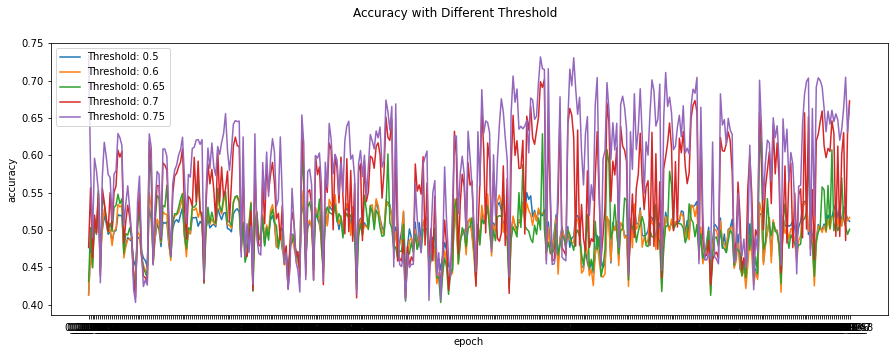

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline


fig = plt.figure(figsize=(15,5))
fig.suptitle('Accuracy with Different Threshold')
# fig = plt.figure()
ax = plt.axes()

for i in [0.5, 0.6, 0.65, 0.7, 0.75]:
    tmp = precisionAndScore[precisionAndScore['Threshhold']==str(i)]
    ax.plot(tmp['Id'], tmp['Accuracy'], label='Threshold: '+str(i))
    print('Threshold: ', i, 'Average Accuracy: ', np.mean(tmp['Accuracy']))

ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('accuracy')  # Add a y-label to the axes.
ax.legend();  # Add a legend.



In [6]:
sorted(precisionAndScore['Accuracy'])[-2]

0.7318573185731857

In [7]:
precisionAndScore[precisionAndScore['Accuracy']==sorted(precisionAndScore['Accuracy'])[-2]]

,Id,Threshhold,Precision0,Precision1,F1-Score,Accuracy
1390,2_2019_6,0.75,53.061224,74.47644,0.839233,0.731857


In [8]:
precisionAndScore[precisionAndScore['F1-Score']==sorted(precisionAndScore['F1-Score'])[-2]]

,Id,Threshhold,Precision0,Precision1,F1-Score,Accuracy
1390,2_2019_6,0.75,53.061224,74.47644,0.839233,0.731857


In [9]:
for i in range(10):
    print(precisionAndScore[precisionAndScore['Accuracy']==sorted(precisionAndScore['Accuracy'])[i]])

            Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
1082  2_2015_1       0.65   37.083923   62.809048  0.206861   0.40274
           Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
148  0_2015_1       0.75   36.406744   64.850498  0.229216  0.403001
           Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
974  2_2013_6       0.65   37.801875   66.954644  0.169751  0.404524
            Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
1048  2_2014_6       0.75   35.598706   53.913043  0.329787   0.40566
           Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
976  2_2013_6       0.75   38.265746   64.864865  0.160267  0.405906
            Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
1084  2_2015_1       0.75   37.470726   62.096774  0.209524   0.40593
           Id Threshhold  Precision0  Precision1  F1-Score  Accuracy
975  2_2013_6        0.7   38.538362   67.513369  0.155768  0.408791
           Id Threshhold  Pr

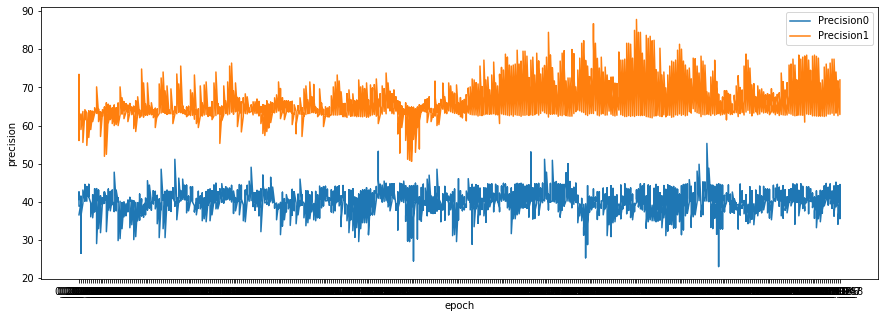

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(15,5))
# fig = plt.figure()
ax = plt.axes()

# for i in label.index:
ax.plot(precisionAndScore['Id'], precisionAndScore['Precision0'], label='Precision0')
ax.plot(precisionAndScore['Id'], precisionAndScore['Precision1'], label='Precision1')

ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('precision')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

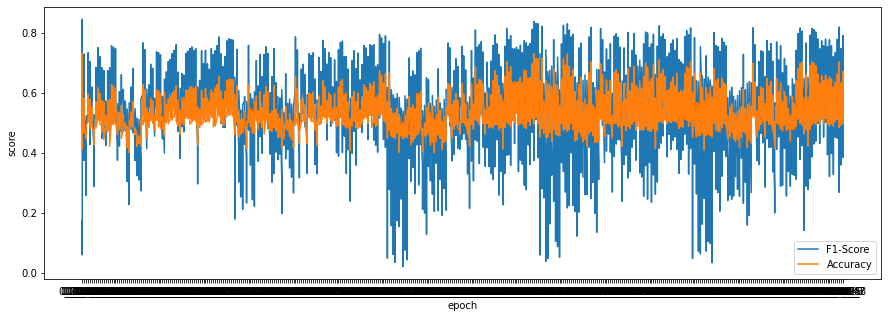

In [12]:
fig = plt.figure(figsize=(15,5))
# fig = plt.figure()
ax = plt.axes()

# for i in label.index:
ax.plot(precisionAndScore['Id'], precisionAndScore['F1-Score'], label='F1-Score')
ax.plot(precisionAndScore['Id'], precisionAndScore['Accuracy'], label='Accuracy')

ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('score')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

In [ ]:
best_performance = {}
for i in [0.5, 0.6, 0.65, 0.7, 0.75, '0.998%']:
    best_performance[str(i)] = {'Epoch':0, 'Year':0, 'F1_Score':0, 'Test_Label_0_Precision':0, 'Test_Label_1_Precision':0}

best_performance = pd.DataFrame(best_performance).T

print(best_performance)

best_performance.to_csv('best_performance.csv')